In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

from my_utils import *

from laplace2D import *

import copy

In [2]:
mu_0 = 1.256637061e-6

In [3]:
my_grid = grid(-0.7e-3,0.7e-3,20e-6,-0.1e-3,0.5e-3,20e-6)

c1 = conductor(-1e-3,1e-3,-0.5e-3,0,V=0.)
c2 = conductor(-200e-6,200e-6,140e-6,160e-6,V=1.)
d1 = dielectric(-1e-3,1e-3,-20e-6,150e-6,eps_r=3.5)
conductor_list = [c1,c2]
dielectric_list = [d1]

In [4]:
V = field(grid=my_grid)
fixed_mask, start_potential = conductors_to_mask(my_grid,conductor_list)
potential = copy.deepcopy(start_potential)
epsilon = gen_dielectric_field(my_grid,dielectric_list)

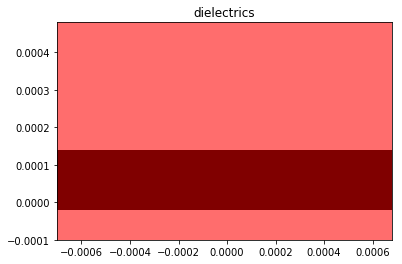

In [5]:

scale= np.max(epsilon.matrix)

plt.pcolormesh(my_grid.X,my_grid.Y,epsilon.matrix,cmap="seismic")
plt.clim(-scale,scale)
plt.title("dielectrics")
plt.show()

In [6]:
for i in range(10000):
    relax_2D_dielectric(potential,fixed_mask,epsilon)

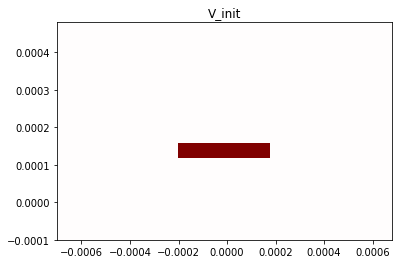

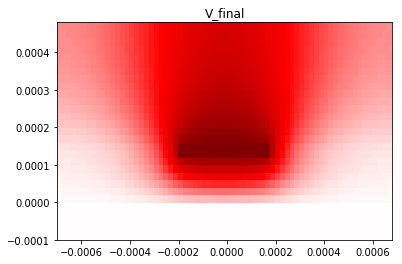

In [7]:
#small_figure()

scale= 1

plt.pcolormesh(my_grid.X,my_grid.Y,start_potential.matrix,cmap="seismic")
plt.clim(-scale,scale)
plt.title("V_init")
plt.show()

plt.pcolormesh(my_grid.X,my_grid.Y,potential.matrix,cmap="seismic")
plt.clim(-scale,scale)
plt.title("V_final")
plt.show()

In [8]:
E = E_from_V(potential)

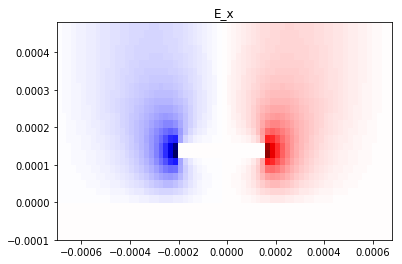

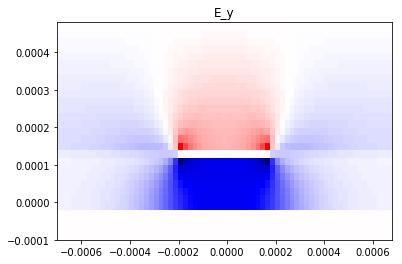

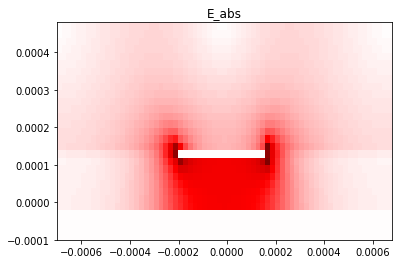

In [9]:
e_abs = np.sqrt(E.matrix[:,:,0]**2 + E.matrix[:,:,1]**2)

scale = np.max(e_abs)


plt.pcolormesh(my_grid.X,my_grid.Y,E.matrix[:,:,0],cmap="seismic")
plt.clim(-scale,scale)
plt.title("E_x")
plt.show()

plt.pcolormesh(my_grid.X,my_grid.Y,E.matrix[:,:,1],cmap="seismic")
plt.clim(-scale,scale)
plt.title("E_y")
plt.show()

plt.pcolormesh(my_grid.X,my_grid.Y,e_abs, cmap='seismic')
plt.clim(-scale,scale)
plt.title("E_abs")
plt.show()

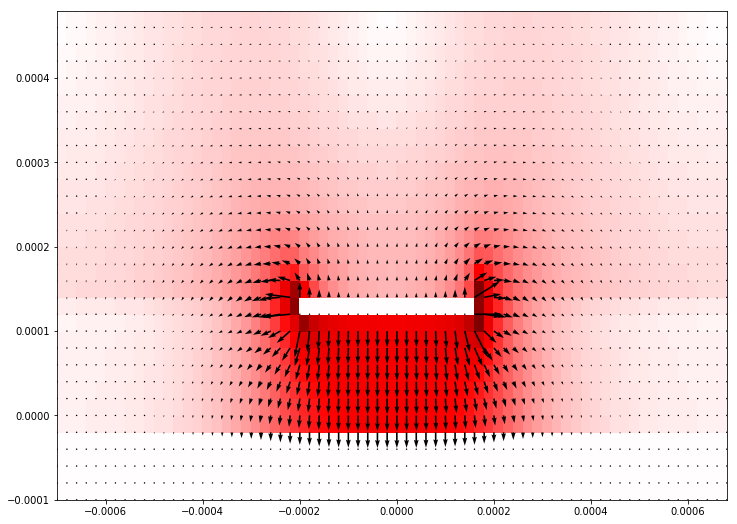

In [10]:
big_figure()

scale = np.max(e_abs)
plt.pcolormesh(my_grid.X,my_grid.Y,e_abs,cmap="seismic")
plt.clim(-scale,scale)
plt.quiver(my_grid.X,my_grid.Y,E.matrix[:,:,0],E.matrix[:,:,1], scale=3e5)

#plt.xlim(-0.8,0.8)
#plt.ylim(-0.3,0.6)
plt.show()

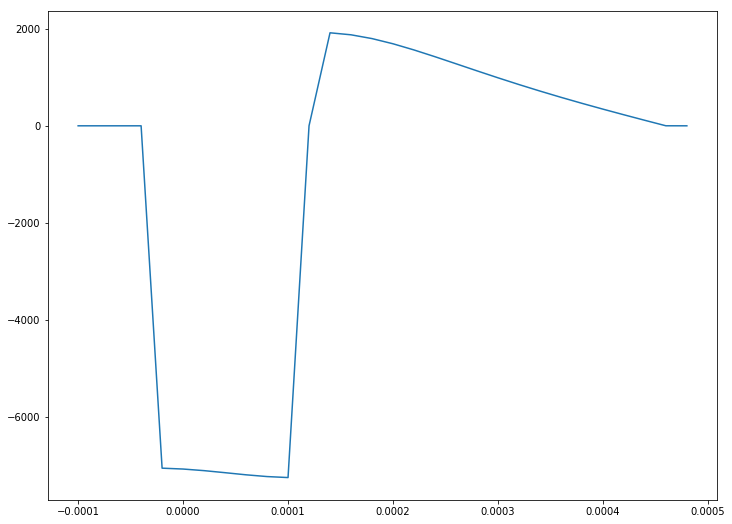

In [11]:
middle_i , middle_j = my_grid.pos_to_index(0,0)

plt.plot(my_grid.y_edges,E.matrix[:,middle_j,1])

In [12]:
rho = rho_from_V(potential,epsilon)

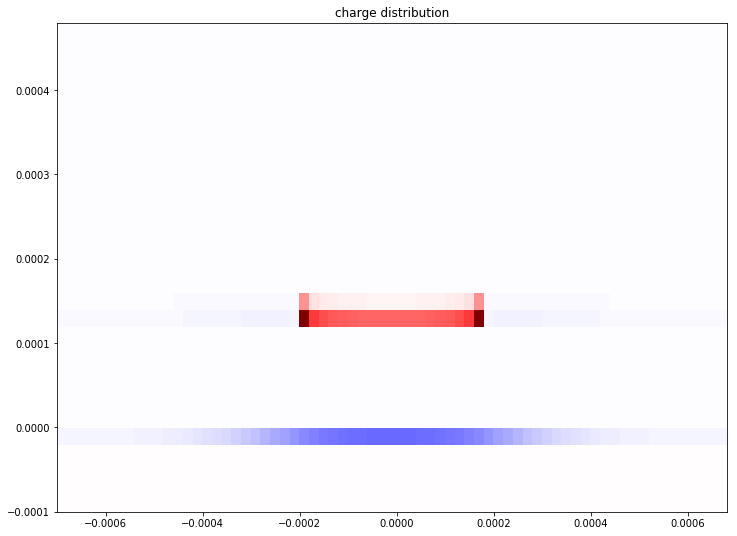

In [13]:
scale = np.max(np.abs(rho.matrix))

plt.pcolormesh(my_grid.X,my_grid.Y,rho.matrix,cmap="seismic")
plt.clim(-scale,scale)
plt.title("charge distribution")
plt.show()

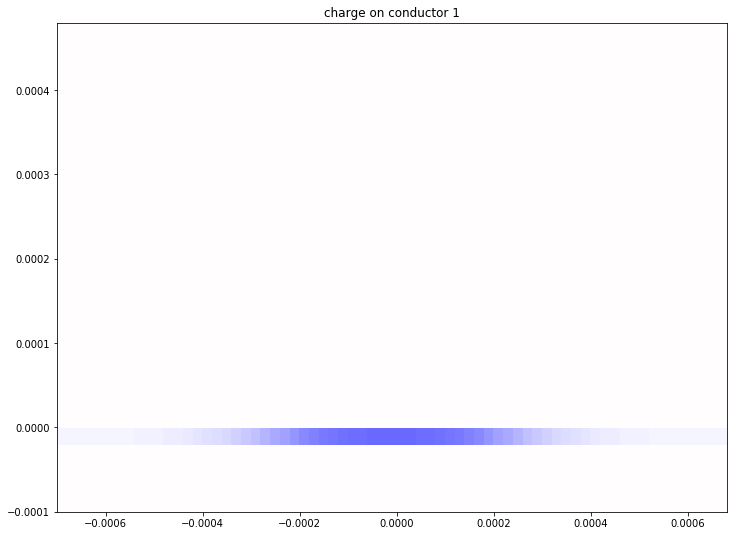

-1.2676375396834782e-10

In [14]:
#scale = 8e-10

area_element = my_grid.x_step * my_grid.y_step

c1_mask, dummy = conductors_to_mask(my_grid,[c1])

plt.pcolormesh(my_grid.X,my_grid.Y,rho.matrix * c1_mask.matrix,cmap="seismic")
plt.clim(-scale,scale)
plt.title("charge on conductor 1")
plt.show()

np.sum(rho.matrix * c1_mask.matrix) * area_element 

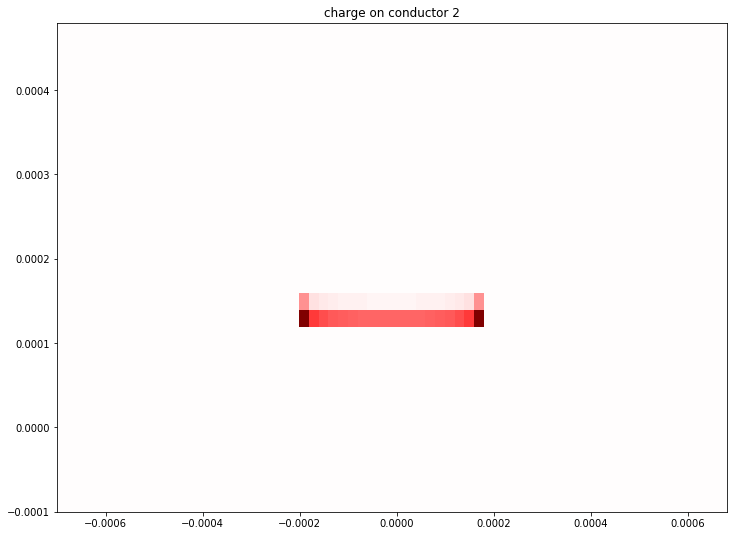

1.2676375423443717e-10

In [15]:
#scale = 8e-10

c2_mask, dummy = conductors_to_mask(my_grid,[c2])

plt.pcolormesh(my_grid.X,my_grid.Y,rho.matrix * c2_mask.matrix,cmap="seismic")
plt.clim(-scale,scale)
plt.title("charge on conductor 2")
plt.show()

np.sum(rho.matrix * c2_mask.matrix) * area_element

In [16]:
from numpy.fft import fft2, ifft2
import numpy as np

def fft_convolve2d(x,y):
    """ 2D convolution, using FFT"""
    fr = fft2(x)
    fr2 = fft2(np.flipud(np.fliplr(y)))
    m,n = fr.shape
    cc = np.real(ifft2(fr*fr2))
    cc = np.roll(cc, int(-m/2+1),axis=0)
    cc = np.roll(cc, int(-n/2+1),axis=1)
    return cc

In [17]:
def B_of_conductor(conductor,rho,fixed_mask):

    my_grid = rho.grid

    B = field(my_grid,nd=2)

    conductor_mask, dummy = conductors_to_mask(my_grid,[conductor])

    I = rho.matrix * conductor_mask.matrix
    signI = np.sign(I)
    I *= signI/np.sum(I)


    inmask = conductor_mask.matrix
    outmask = 1-fixed_mask.matrix

    x_step = my_grid.x_step
    y_step = my_grid.y_step


    leni, lenj = I.shape

    for i in range(leni):
        for j in range(lenj):

            if not(outmask[i,j]):
                continue

            for ii in range(leni):
                for jj in range(lenj):

                    if not(inmask[ii,jj]):
                        continue
                    dy = y_step*(ii-i)    
                    dx = x_step*(jj-j)
                    d  = np.sqrt(dx**2+dy**2)
                    B.matrix[i,j,0] += 1./d**3 * I[ii,jj] * (-dy)
                    B.matrix[i,j,1] += 1./d**3 * I[ii,jj] * ( dx)
    B.matrix *= mu_0/(2*np.pi)
    return B
                
        
        




In [18]:
B1 = B_of_conductor(c1,rho,fixed_mask)
B2 = B_of_conductor(c2,rho,fixed_mask)

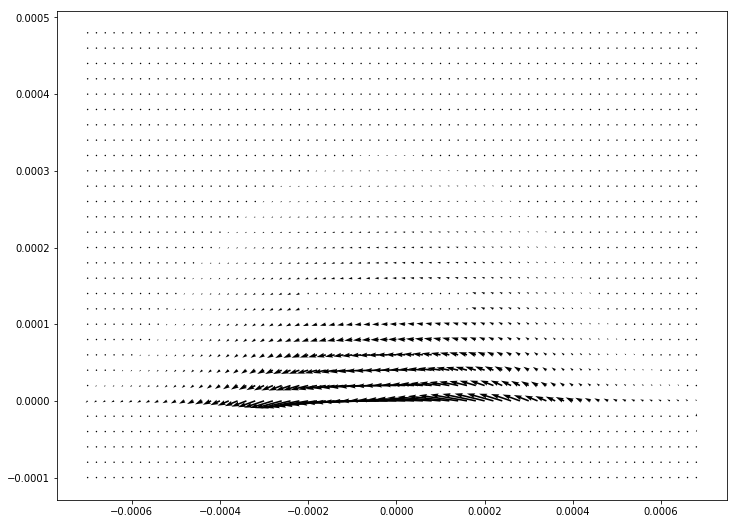

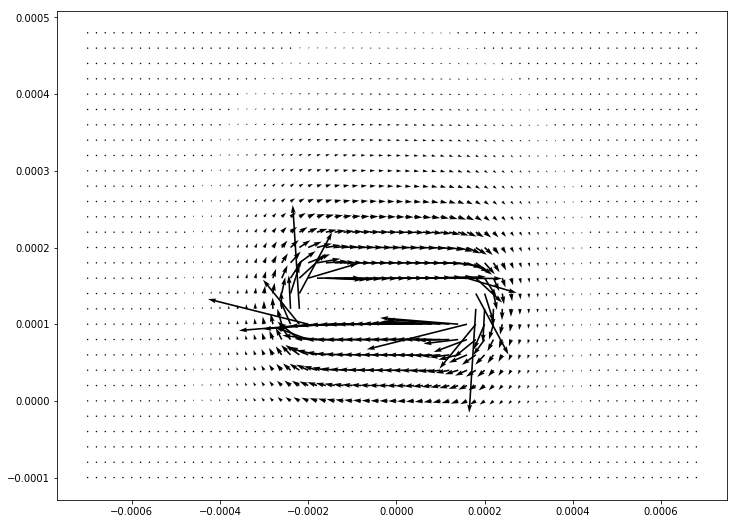

In [19]:
plt.quiver(my_grid.X,my_grid.Y,B1.matrix[:,:,0],B1.matrix[:,:,1], scale=500)
plt.show()
plt.quiver(my_grid.X,my_grid.Y,B2.matrix[:,:,0],B2.matrix[:,:,1], scale=500)
plt.show()

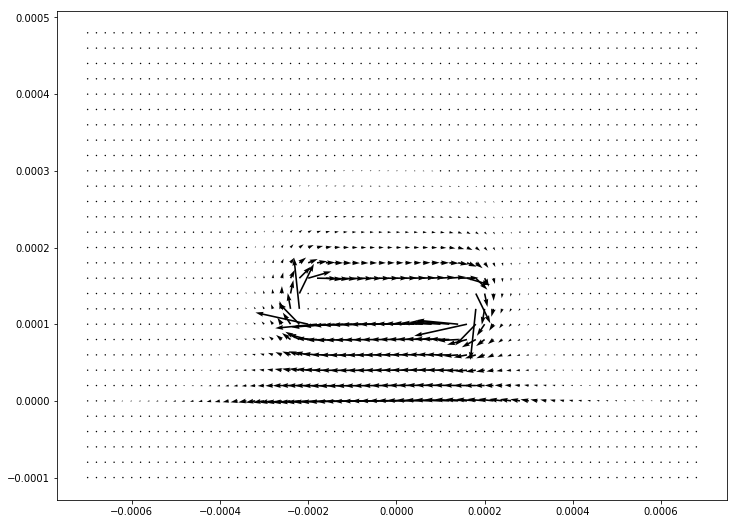

In [20]:
B = field(my_grid,nd=2)
B.matrix= B1.matrix+B2.matrix

plt.quiver(my_grid.X,my_grid.Y,B.matrix[:,:,0],B.matrix[:,:,1], scale=1000)
plt.show()

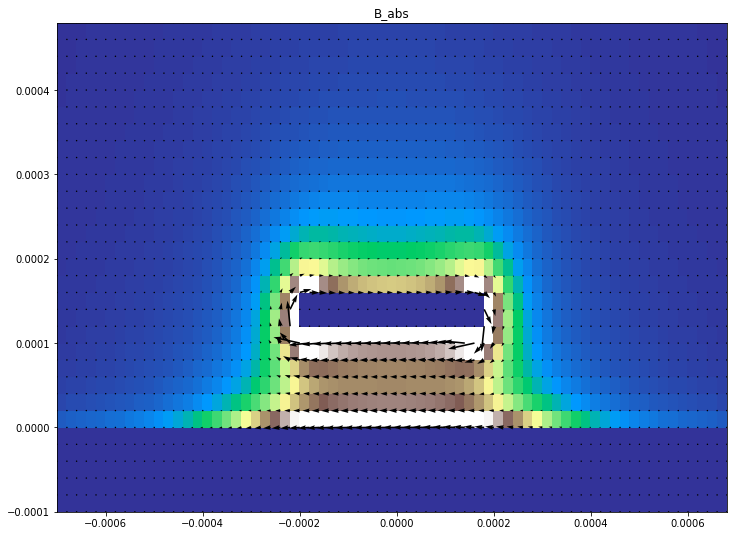

In [21]:
b_abs = np.sqrt(B.matrix[:,:,0]**2 + B.matrix[:,:,1]**2)

scale = np.max(b_abs)

cmap="seismic"
cmap="terrain"

scale = 30


plt.pcolormesh(my_grid.X,my_grid.Y,b_abs, cmap=cmap)
plt.clim(0,scale)
plt.quiver(my_grid.X,my_grid.Y,B.matrix[:,:,0],B.matrix[:,:,1], scale=2000)
plt.title("B_abs")
plt.show()